# Load ds005514 and start training (see below to read presaved data)

In [ ]:
# This will be replace with one line of code with the EEGDashDataset object
# We need to resolve the binary labels -- Dung said there was a solution with Braindecode

import os
from eegdash import EEGDashDataset

eegdash_braindecode = EEGDashDataset({'dataset': 'ds005505', 'task': 'RestingState'}, target_name='sex')


/Users/arno/Python/EEG-Dash-Data/src/eegdash/data_utils.py:51: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  self.raw = mne_bids.read_raw_bids(self.bidspath, verbose=False)
/Users/arno/Python/EEG-Dash-Data/src/eegdash/data_utils.py:51: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  self.raw = mne_bids.read_raw_bids(self.bidspath, verbose=False)
/Users/arno/Python/EEG-Dash-Data/src/eegdash/data_utils.py:51: RuntimeWarning: Unable to map the following column(s) to to MNE:
release_number: R1
ehq_total: 57.83
commercial_use: Yes
full_pheno: Yes
p_factor: -0.648
attention: -0.055
internalizing: -0.051
externalizing: -0.109
RestingState: available
DespicableMe: available
FunwithFractals: available
ThePresent: available
DiaryOfAWimpyKid: available
contrastChangeDetection_1: unavailable
contrastChangeDetectio

In [ ]:
from braindecode.preprocessing import (preprocess, Preprocessor, create_fixed_length_windows)

# Alternatively, if you want to include this as a preprocessing step in a Braindecode pipeline:
preprocessors = [
    Preprocessor('pick_channels', ch_names=['E22', 'E9', 'E33', 'E24', 'E11', 'E124', 'E122', 'E29', 'E6', 'E111', 'E45', 'E36', 'E104', 'E108', 'E42', 'E55', 'E93', 'E58', 'E52', 'E62', 'E92', 'E96', 'E70', 'Cz']),
    Preprocessor("resample", sfreq=128),
    Preprocessor("filter", l_freq=1, h_freq=55)
]
preprocess(eegdash_braindecode, preprocessors, n_jobs=-1) #, save_dir='xxxx'' will save and set preload to false

# extract windows and save to disk
windows_ds = create_fixed_length_windows(eegdash_braindecode, start_offset_samples=0, stop_offset_samples=None,
        window_size_samples=256, window_stride_samples=256, drop_last_window=True, preload=False) 
os.makedirs('data/hbn_preprocessed_restingstate', exist_ok=True)
windows_ds.save('data/hbn_preprocessed_restingstate', overwrite=True)

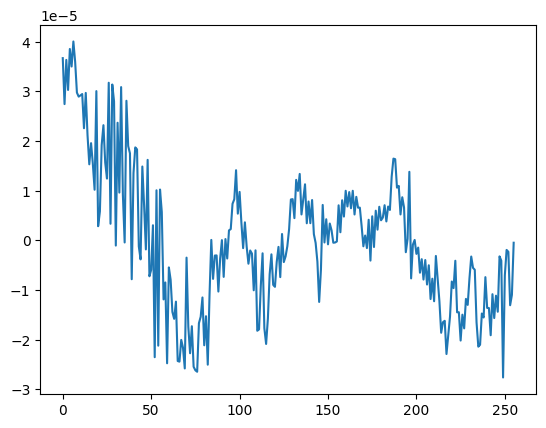

In [19]:
# ************
# ************
# ************
# INVESTIGATE WHY SOME CHANNEL HAVE STRONG NOISE, PROBABLY DUE TO FILTERING (not this one)
# ************
# ************
# ************

import matplotlib.pyplot as plt
plt.figure()
plt.plot(windows_ds[1000][0][0,:].transpose()) # first channel of first epoch
plt.show()

# Start here to load presaved data

In [1]:
from braindecode.datautil import load_concat_dataset

print("Loading data from disk")
windows_ds = load_concat_dataset(path='data/hbn_preprocessed_restingstate', preload=False)


Loading data from disk


In [40]:
from braindecode.datasets import BaseDataset, BaseConcatDataset
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

subject_genders = windows_ds.description['sex']
assert  len(subject_genders) == len(windows_ds.description)
random_state = 0
np.random.seed(random_state)

# Get balanced indices for male and female subjects
male_subjects = windows_ds.description['subject'][windows_ds.description['sex'] == 'M']
male_gender = windows_ds.description['sex'][windows_ds.description['sex'] == 'M'] 
female_subjects = windows_ds.description['subject'][windows_ds.description['sex'] == 'F']
female_gender = windows_ds.description['sex'][windows_ds.description['sex'] == 'F'] 
n_samples = min(len(male_subjects), len(female_subjects))
balanced_subjects = np.concatenate([male_subjects[:n_samples], female_subjects[:n_samples]])
balanced_gender = np.concatenate([male_gender[:n_samples], female_gender[:n_samples]])

assert len(balanced_subjects) == len(balanced_gender)
print(f"Number of subjects in balanced dataset: {len(balanced_subjects)}")
print(f"Gender distribution in balanced dataset: {np.unique(balanced_gender, return_counts=True)}")

Number of subjects in balanced dataset: 92
Gender distribution in balanced dataset: (array(['F', 'M'], dtype=object), array([46, 46]))


In [41]:
train_subj, val_subj, train_gender, val_gender = train_test_split(balanced_subjects, balanced_gender, train_size=0.9, stratify=balanced_gender, random_state=random_state)

# Create datasets
train_ds = BaseConcatDataset([ds for ds in windows_ds.datasets if ds.description.subject in train_subj])
val_ds = BaseConcatDataset([ds for ds in windows_ds.datasets if ds.description.subject in val_subj])

# Create dataloaders
batch_size = 100
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader =  DataLoader(val_ds, batch_size=batch_size, shuffle=True)

In [42]:
dataiter = iter(train_loader)
first_item, label, sz = dataiter.__next__() # question why is the label lost here 
np.array(label).T

array(['M', 'M', 'M', 'F', 'F', 'M', 'F', 'M', 'M', 'M', 'F', 'F', 'F',
       'M', 'F', 'F', 'F', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'M', 'F',
       'M', 'F', 'F', 'M', 'F', 'F', 'M', 'F', 'F', 'F', 'M', 'F', 'M',
       'M', 'M', 'F', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'F', 'F',
       'F', 'F', 'F', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'F',
       'M', 'M', 'M', 'M', 'F', 'M', 'F', 'M', 'F', 'F', 'F', 'M', 'M',
       'M', 'M', 'F', 'F', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'F',
       'F', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'F'], dtype='<U1')

In [43]:
# create model
from torchinfo import summary
from torch import nn

model = nn.Sequential(
    # First VGG block
    nn.Conv2d(1, 16, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    # Second VGG block
    nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    # Third VGG block
    nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    # Flatten and FC layers
    nn.Flatten(),
    nn.Linear(64 * 3 * 32, 1024), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 1024), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 2)
)

print(summary(model, input_size=(1, 1, 24, 256)))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Conv2d: 1-1                            [1, 16, 24, 256]          160
├─ReLU: 1-2                              [1, 16, 24, 256]          --
├─Conv2d: 1-3                            [1, 16, 24, 256]          2,320
├─ReLU: 1-4                              [1, 16, 24, 256]          --
├─MaxPool2d: 1-5                         [1, 16, 12, 128]          --
├─Conv2d: 1-6                            [1, 32, 12, 128]          4,640
├─ReLU: 1-7                              [1, 32, 12, 128]          --
├─Conv2d: 1-8                            [1, 32, 12, 128]          9,248
├─ReLU: 1-9                              [1, 32, 12, 128]          --
├─MaxPool2d: 1-10                        [1, 32, 6, 64]            --
├─Conv2d: 1-11                           [1, 64, 6, 64]            18,496
├─ReLU: 1-12                             [1, 64, 6, 64]            --
├

In [44]:

import torch
from torch.nn import functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, weight_decay=0.001)
model = model.to(device=device)  # move the model parameters to CPU/GPU

def normalize_data(x):
    x = x.reshape(x.shape[0], 1, 24, 256)
    mean = x.mean(dim=3, keepdim=True)
    std = x.std(dim=3, keepdim=True) + 1e-7  # add small epsilon for numerical stability
    x = (x - mean) / std
    x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
    return x

# dictionary of genders and their gender
gender_dict = {'M': 0, 'F': 1}

epochs = 2
for e in range(epochs):
    
    # training
    results_train = np.array([])
    for t, (x, y, sz) in enumerate(train_loader):
        model.train()  # put model to training mode
        scores = model(normalize_data(x))
        y = torch.tensor([gender_dict[gender] for gender in y], device=device, dtype=torch.long)
        loss = F.cross_entropy(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        results_train = np.concatenate((results_train, (scores.max(1).indices.cpu().numpy() == y.cpu().numpy())))

        if t % 100 == 0:
            print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
    
    # validation
    results_test = np.array([])
    for t, (x, y, sz) in enumerate(val_loader):
        model.eval()
        y = torch.tensor([gender_dict[gender] for gender in y], device=device, dtype=torch.long)
        scores = model(normalize_data(x))
        results_test = np.concatenate((results_test, (scores.max(1).indices.cpu().numpy() == y.cpu().numpy())))

    print(f'Epoch {e}, Train accuracy: {np.mean(results_train):.2f}, Test accuracy: {np.mean(results_test):.2f}')


Epoch 0, Iteration 0, loss = 0.6939
Epoch 0, Iteration 100, loss = 0.2224
Epoch 0, Train accuracy: 0.81, Test accuracy: 0.78
Epoch 1, Iteration 0, loss = 0.2836
Epoch 1, Iteration 100, loss = 0.0977
Epoch 1, Train accuracy: 0.94, Test accuracy: 0.81
Epoch 2, Iteration 0, loss = 0.1098
Epoch 2, Iteration 100, loss = 0.1030
Epoch 2, Train accuracy: 0.98, Test accuracy: 0.82
Epoch 3, Iteration 0, loss = 0.1463
Epoch 3, Iteration 100, loss = 0.0271
Epoch 3, Train accuracy: 0.98, Test accuracy: 0.79


In [18]:
# other solution for testing

num_correct = 0
num_samples = 0
model.eval()  # set model to evaluation mode
with torch.no_grad():
    for x, y, sz in val_loader:
        x = x.reshape(x.shape[0], 1, 24, 256)
        
        # normalize each channel
        mean = x.mean(dim=3, keepdim=True)
        std = x.std(dim=3, keepdim=True) + 1e-7  # add small epsilon for numerical stability
        x = (x - mean) / std

        x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
        y = torch.tensor([gender_dict[gender] for gender in y], device=device, dtype=torch.long)
        scores = model(x)
        _, preds = scores.max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

Got 2920 / 3729 correct (78.31)
